In [1]:
import gc
from pathlib import Path

import numpy as np
import pandas as pd

from keras.preprocessing.image import load_img, array_to_img
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")
%matplotlib inline

/home/jun/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
data_dir = Path("data")
train_imgs_dir = data_dir / "train/images"
train_masks_dir = data_dir / "train/masks"
test_imgs_dir = data_dir / "test/images"

In [3]:
mask1 = np.array(load_img("data/train/masks/a00d2b180c.png", grayscale=True))

In [6]:
mask1.dtype, mask1.shape,  mask1[0, :3]

(dtype('uint8'), (101, 101), array([0, 0, 0], dtype=uint8))

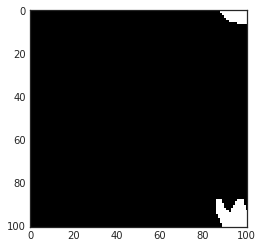

In [5]:
plt.imshow(mask1, cmap="gray")

In [8]:
img1 = array_to_img(mask1[..., np.newaxis])

In [9]:
img1.save("a00d2b180c.png")

In [3]:
import pandas as pd
train_df = pd.read_csv('data/train.csv', index_col='id', usecols=[0])
depth_df = pd.read_csv('data/depths.csv', index_col='id')
train_df['z'] = depth_df.loc[train_df.index, 'z']
test_df = depth_df[~depth_df.index.isin(train_df.index)]
print('num of train samples: {}, num of test samples: {}'.format(len(train_df), len(test_df)))

num of train samples: 4000, num of test samples: 18000


In [29]:
from keras.preprocessing import image
from tqdm import tqdm

In [4]:
train_imgs = [np.array(image.load_img(str(train_imgs_dir / (f + ".png")), grayscale=True)) / 255 for f in tqdm(train_df.index)] 

100%|██████████| 4000/4000 [00:23<00:00, 167.77it/s]


In [5]:
train_masks = [np.array(image.load_img(str(train_masks_dir / (f + ".png")), grayscale=True)) / 255 for f in tqdm(train_df.index)]

100%|██████████| 4000/4000 [00:09<00:00, 433.17it/s]


In [8]:
train_df['coverage'] = [np.mean(img) for img in train_masks]

In [9]:
train_df['coverage_class'] = train_df['coverage'].apply(lambda x: np.ceil(x * 10)).astype(np.int32)

In [37]:
arr = np.array(image.load_img(str(train_imgs_dir / (train_df.index[0] + ".png")), grayscale=False))

In [38]:
arr.dtype, arr.shape

(dtype('uint8'), (101, 101, 3))

In [10]:
train_df.loc[:, train_df.columns.str.startswith('coverage')][:10]

,coverage,coverage_class
id,,
575d24d81d,0.000000,0
a266a2a9df,0.504950,6
75efad62c1,0.993334,10
34e51dba6a,0.149201,2
4875705fb0,0.042839,1
782ae9b7e7,0.225370,3
9842f69f8d,0.000000,0
aa94cfb806,0.665817,7
50d3073821,0.297030,3


Text(0.5,0,'Coverage Class')

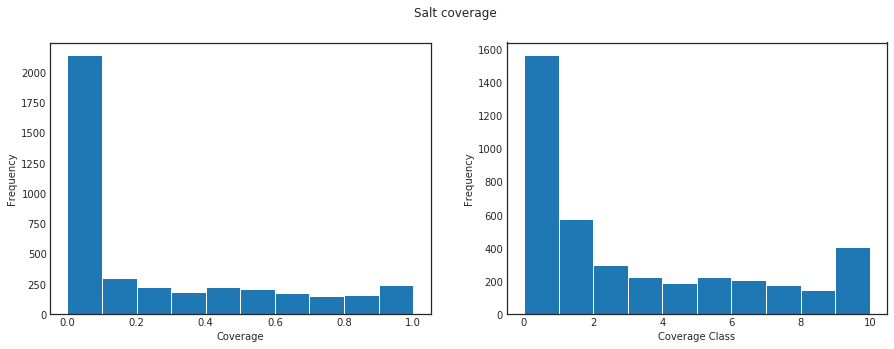

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
train_df['coverage'].plot.hist(ax=axes[0])
train_df['coverage_class'].plot.hist(ax=axes[1])
plt.suptitle("Salt coverage")
axes[0].set_xlabel("Coverage")
axes[1].set_xlabel("Coverage Class")

Text(0,0.5,'Coverage Class')

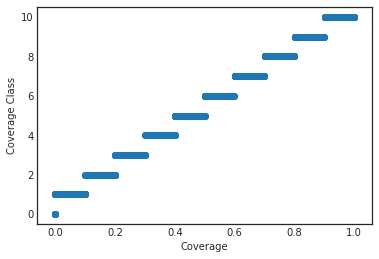

In [12]:
plt.scatter(train_df.coverage, train_df.coverage_class)
plt.xlabel("Coverage")
plt.ylabel("Coverage Class")

In [16]:
coverage_class_cnt = train_df[['coverage_class', 'coverage']].groupby('coverage_class').count()

print(coverage_class_cnt)

                coverage
coverage_class          
0                   1562
1                    576
2                    296
3                    224
4                    186
5                    225
6                    205
7                    174
8                    148
9                    159
10                   245


In [22]:
train_df['coverage_class_cnt'] = train_df['coverage_class'].apply(lambda c: coverage_class_cnt.loc[c, 'coverage'])
train_df.head(20)

,z,coverage,coverage_class,coverage_class_cnt
id,,,,
575d24d81d,843,0.000000,0,1562
a266a2a9df,794,0.504950,6,205
75efad62c1,468,0.993334,10,245
34e51dba6a,727,0.149201,2,296
4875705fb0,797,0.042839,1,576
782ae9b7e7,677,0.225370,3,224
9842f69f8d,907,0.000000,0,1562
aa94cfb806,754,0.665817,7,174
50d3073821,810,0.297030,3,224


In [23]:
train_df.to_csv("data/train_df.csv")

In [24]:
test_df.to_csv("data/test_df.csv")

Text(0.5,1,'Depth distribution')

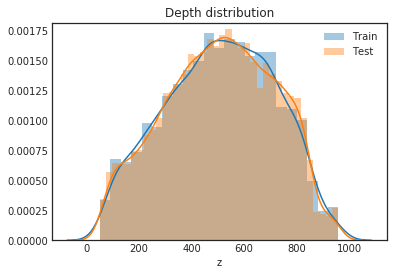

In [106]:
sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

In [25]:
from sklearn.model_selection import KFold

In [29]:
kf = KFold(5)

ids = np.arange(9)

list(kf.split(ids))

[(array([2, 3, 4, 5, 6, 7, 8]), array([0, 1])),
 (array([0, 1, 4, 5, 6, 7, 8]), array([2, 3])),
 (array([0, 1, 2, 3, 6, 7, 8]), array([4, 5])),
 (array([0, 1, 2, 3, 4, 5, 8]), array([6, 7])),
 (array([0, 1, 2, 3, 4, 5, 6, 7]), array([8]))]

In [73]:
np.random.choice(train_df.index, 10)

array(['7410f440bb', 'fa2ebd1083', '27c035c5ae', '6c557220d3',
       'e88b8de75c', '6bffabbd91', '638d8572e9', 'b76760a4a1',
       '7e138bf911', '675cab373f'], dtype=object)

In [113]:
from skimage.transform import resize
img_size_ori = 101
img_size_target = 128

def upsample(img):
    return resize(img, (img_size_target, img_size_target), mode="constant", preserve_range=True)

def downsample(img):
    return resize(img, (img_size_ori, img_size_ori), mode="constant", preserve_range=True)

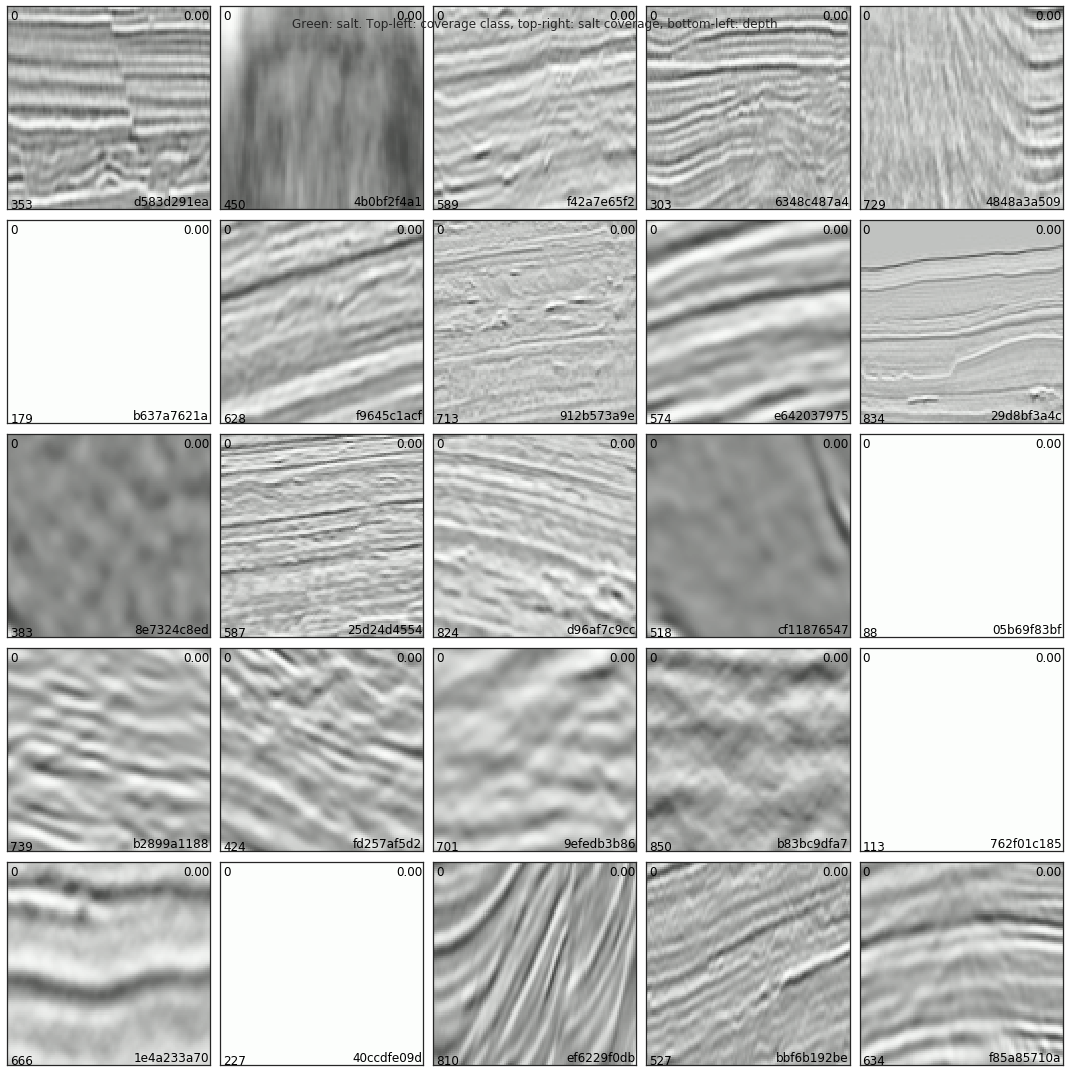

In [107]:
max_images = 25
grid_width = 5
grid_height = int(np.ceil(max_images / grid_width))
color = 'black'
fontsize = 12
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*3, grid_height*3))
coverage_mask = train_df['coverage_class'] == 0

for i, idx in enumerate(np.random.choice(train_df[coverage_mask].index, max_images, replace=False)):
    img = train_df.loc[idx, 'image']
    mask = train_df.loc[idx, 'mask']
    ax = axs[i//grid_width, i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, cmap="Greens", alpha=0.3)
    ax.text(1, img_size_ori-1, train_df.loc[idx, 'z'], color='black', fontsize=12)
    ax.text(img_size_ori-1, 1, '{:.2f}'.format(train_df.loc[idx, 'coverage']), color='black', ha='right', va='top', fontsize=12)
    ax.text(1, 1, train_df.loc[idx, 'coverage_class'], color='black', ha='left', va='top', fontsize=12)
    ax.text(img_size_ori-1, img_size_ori-1, idx, color=color, fontsize=fontsize, ha='right', va='bottom') 
    ax.set_yticklabels([])
    ax.set_xticklabels([])

plt.suptitle("Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")
plt.tight_layout()

In [42]:
depth_df.to_csv('data/data.csv', index=None)

In [117]:
ids_train, ids_valid = train_test_split(train_df.index.values, test_size=0.2, stratify=train_df['coverage_class'],
                                        random_state=43)
x_train = train_df.loc[ids_train, 'image'].map(upsample)
x_valid = train_df.loc[ids_valid, 'mask'].map(upsample)

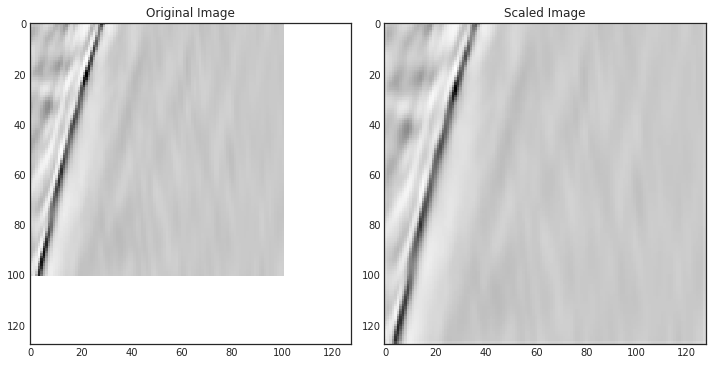

In [124]:
tmp_img = np.zeros((img_size_target, img_size_target), dtype=np.float32)
idx = ids_train[10]
tmp_img[:img_size_ori, :img_size_ori] = train_df.loc[idx, 'image']
fix, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(tmp_img, cmap="Greys")
axs[0].set_title("Original Image")
axs[1].imshow(x_train[10], cmap="Greys")
axs[1].set_title("Scaled Image")
plt.tight_layout()

## Build model

In [143]:
ACTIVATION = "relu"
USE_BN = True
USE_RESIDUAL = False
DROP_RATE = 0.5
USE_UPSAMPLING = True


from keras.layers import Conv2D, BatchNormalization, Dropout, Concatenate
from keras.layers import MaxPool2D, UpSampling2D, Conv2DTranspose, Input
from keras.models import Model
import keras.backend as K

# input: n_channels, (mxm)
# output: n_channels, (m x m)
def conv_block(inputs, n_channels, dropout=0.0):
    n = Conv2D(n_channels, kernel_size=3, activation=ACTIVATION, padding="same")(inputs)
    n = BatchNormalization()(n) if USE_BN else n
    n = Dropout(dropout)(n) if dropout else n
    n = Conv2D(n_channels, kernel_size=3, activation=ACTIVATION, padding="same")(n)
    n = BatchNormalization()(n) if USE_BN else n
    return n
    # Concatenate()([inputs, n]) if USE_RESIDUAL else n

def up_block(inputs, conv_outputs, conv_channels):
    x = inputs
    
    for conv_ch, conv_x in zip(conv_channels[::-1], conv_outputs[::-1]):
        if USE_UPSAMPLING:
            x = UpSampling2D()(x)
            x = Conv2D(conv_ch, kernel_size=2, activation=ACTIVATION, padding="same")(x)
        else:
            x = Conv2DTranspose(conv_ch, kernel_size=3, strides=2, activation=ACTIVATION, padding="same")(x)
        x = Concatenate()([conv_x, x])
        x = conv_block(x, conv_ch)
    return x
    

def UNet():
    inputs = Input(shape=(img_size_target, img_size_target, 1))
    x = inputs
    
    # 128x128x1
    # 64x64x16
    # 32x32x32
    # 16x16x64
    # 8x8x128
    # 4x4x256
    conv_channels = [16, 32, 64, 128, 256]
    conv_outputs = []
    for n_channels in conv_channels:
        x = conv_block(x, n_channels)
        conv_outputs.append(x)
        x = MaxPool2D()(x)
    # middle: 4x4x512
    x = conv_block(x, 512, dropout=DROP_RATE)
    
    # 128x128x16
    x = up_block(x, conv_outputs, conv_channels)
    
    # last layer: 128x128x16
    outputs = Conv2D(1, kernel_size=1, activation='sigmoid')(x)
    return Model(inputs=inputs, outputs=outputs)
    
    

In [145]:
from keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2.0 * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2.0 * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1 - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [146]:
model = UNet()
model.compile(loss=bce_dice_loss, optimizer='adam', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_87 (Conv2D)              (None, 128, 128, 16) 160         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_78 (BatchNo (None, 128, 128, 16) 64          conv2d_87[0][0]                  
__________________________________________________________________________________________________
conv2d_88 (Conv2D)              (None, 128, 128, 16) 2320        batch_normalization_78[0][0]     
__________________________________________________________________________________________________
batch_norm

In [ ]:
x_train_list = x_train.tolist()
x_train_list.extend((np.fliplr(x) for x in x_train_list))

In [43]:
train_set[6]

'ee7ff3b2fe.png'

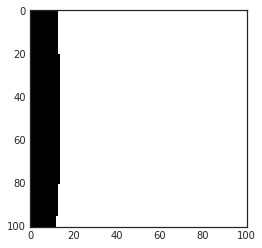

In [21]:
plt.imshow(masks_tr[6], cmap='Greys')

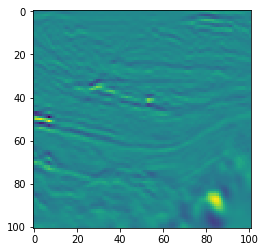

In [18]:
plt.imshow(arr[:,:,0])

In [19]:
help(plt.colormaps)

Help on function colormaps in module matplotlib.pyplot:

colormaps()
    Matplotlib provides a number of colormaps, and others can be added using
    :func:`~matplotlib.cm.register_cmap`.  This function documents the built-in
    colormaps, and will also return a list of all registered colormaps if called.
    
    You can set the colormap for an image, pcolor, scatter, etc,
    using a keyword argument::
    
      imshow(X, cmap=cm.hot)
    
    or using the :func:`set_cmap` function::
    
      imshow(X)
      pyplot.set_cmap('hot')
      pyplot.set_cmap('jet')
    
    In interactive mode, :func:`set_cmap` will update the colormap post-hoc,
    allowing you to see which one works best for your data.
    
    All built-in colormaps can be reversed by appending ``_r``: For instance,
    ``gray_r`` is the reverse of ``gray``.
    
    There are several common color schemes used in visualization:
    
    Sequential schemes
      for unipolar data that progresses from low to high
    